## Web scraping and analysis

This Jupyter notebook includes some code to get started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once we've collected the data and saved it into a local `.csv` file we should start with our analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd


In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | 4 Hours before takeoff we r...
1,✅ Trip Verified | I recently had a delay on B...
2,"Not Verified | Boarded on time, but it took a..."
3,"✅ Trip Verified | 5 days before the flight, w..."
4,Not Verified | \r\nWe traveled to Lisbon for ...


In [4]:
df.to_csv("BA_reviews.csv")
import re

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

Processed the reviews to remove the ✅Verified/Not Verified parts of the reviews.

In [5]:
df['reviews']=df['reviews'].str.split('|', n=1).str[1].str.strip()
df.head()

,reviews
0,4 Hours before takeoff we received a Mail stat...
1,I recently had a delay on British Airways from...
2,"Boarded on time, but it took ages to get to th..."
3,"5 days before the flight, we were advised by B..."
4,"We traveled to Lisbon for our dream vacation, ..."


In [6]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch
torch.cuda.is_available()

True

In [7]:
from flair.data import Sentence
from flair.nn import Classifier
# load the NER tagger
tagger = Classifier.load('sentiment')


In [8]:
def polarity_scores(text):
    sentence = Sentence(text)
    tagger.predict(sentence)
    sentiment=sentence.labels[0].value
    confidence=sentence.labels[0].score
    return sentiment,confidence

In [9]:
MODEL=f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [10]:
example=df['reviews'][1]
print(example)
encoded_text=tokenizer(example,return_tensors='pt')
output = model(**encoded_text)
scores=output[0][0].detach().numpy()
scores = softmax(scores)
print(scores)
scores_dict={
    'roberta_negative': scores[0]*100,
    'roberta_neutral': scores[1]*100,
    'roberta_positive': scores[2]*100,
}
print(scores_dict)

I recently had a delay on British Airways from BRU to LHR that was due to staff shortages. They announced that there was a 2 hour holding delay but they would board us immediately in hopes of clearing the gate and leaving early. We had to wait the full 2 hours inside the airplane. The plane was old, dirty, had no power at the seats. The staff provided a small bag of pretzels and 250ml of water to the passengers for 2 hour delay and 2 hour flight. There were no options to purchase food or drink. There were no entertainment options available. I am a OneWorld emerald elite member but they do not upgrade members based on status. First class lounges at Heathrow are overcrowded, understaffed and poorly equipped. The help desk is completely unhelpful when an error arises with delays and cancellations - even when having the top status. The Avios points system has been devalued to near worthlessness and requires fees to book reward that nearly equal the price of the revenue ticket. British has 

from langchain.text_splitter import NLTKTextSplitter
import nltk
nltk.download('punkt')
text_splitter = NLTKTextSplitter(chunk_size=1000)
texts = text_splitter.split_text(example)
print(texts[0])


from langchain.text_splitter import RecursiveCharacterTextSplitter
example=df['reviews'][1]
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 400,
    chunk_overlap  = 20,
    length_function = len,
    add_start_index = True,
    separators=['\n\n','\n',' ','']
)
texts = text_splitter.split_text(example)
for i in texts:
    print(i)
    print(len(i))

In [11]:
def polarity_scores(text):
    if len(text)>514:
        text=text[:514]
    encoded_text=tokenizer(text,return_tensors='pt')
    output = model(**encoded_text)
    scores=output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict={
        'Negative': scores[0],
        'Neutral': scores[1],
        'Positive': scores[2],
    }
    return max(scores_dict, key=lambda k: scores_dict[k]),max(scores_dict.values())

In [12]:
%%time
df[['sentiment', 'confidence']] = df['reviews'].apply(lambda x: pd.Series(polarity_scores(x)))


CPU times: total: 15min 8s
Wall time: 2min 46s


In [13]:
df.head()

,reviews,sentiment,confidence
0,4 Hours before takeoff we received a Mail stat...,Negative,0.519520
1,I recently had a delay on British Airways from...,Negative,0.811407
2,"Boarded on time, but it took ages to get to th...",Positive,0.722829
3,"5 days before the flight, we were advised by B...",Neutral,0.516682
4,"We traveled to Lisbon for our dream vacation, ...",Negative,0.793575


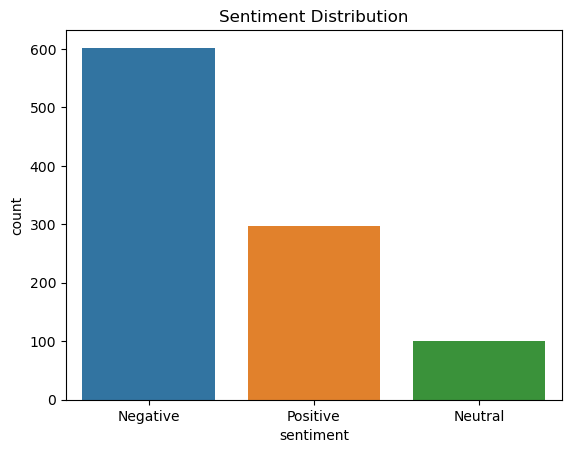

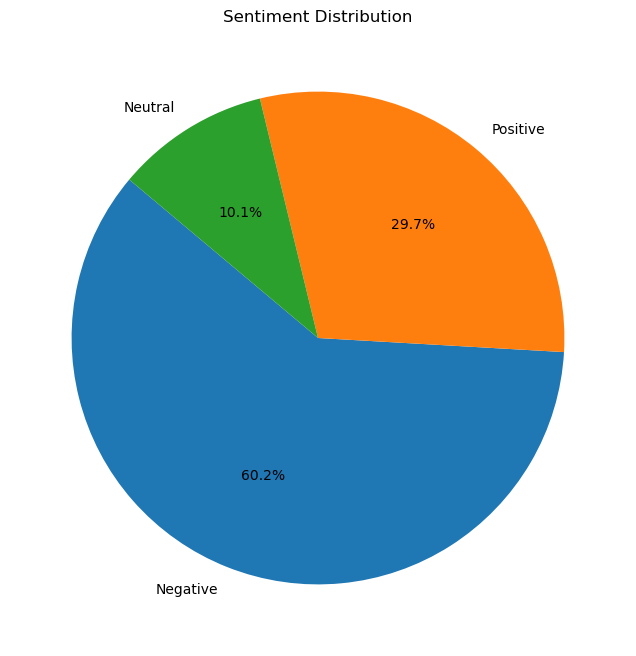

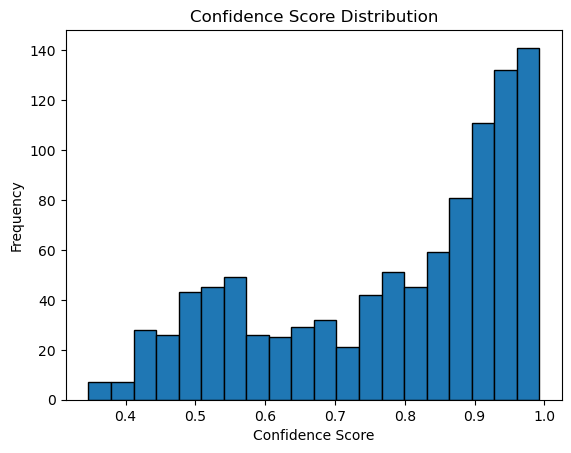

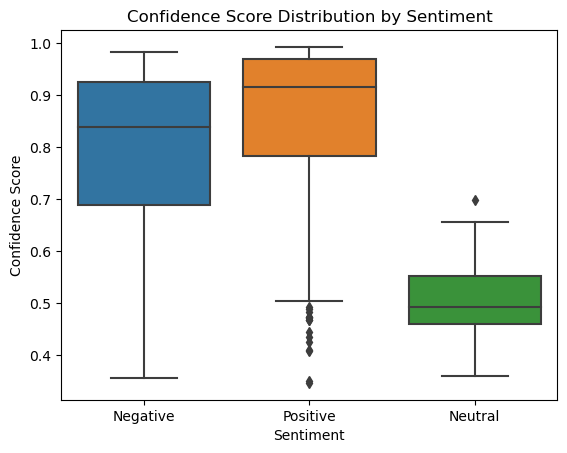

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'sentiment' is the column containing sentiment labels in your DataFrame
sns.countplot(data=df, x='sentiment')
plt.title('Sentiment Distribution')
plt.show()

# Count the number of occurrences of each sentiment label
sentiment_counts = df['sentiment'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.show()

# Assuming 'confidence' is the column containing confidence scores in your DataFrame
plt.hist(df['confidence'], bins=20, edgecolor='black')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Score Distribution')
plt.show()

sns.boxplot(data=df, x='sentiment', y='confidence')
plt.xlabel('Sentiment')
plt.ylabel('Confidence Score')
plt.title('Confidence Score Distribution by Sentiment')
plt.show()


In [31]:
positive_df = df[df['sentiment'] == 'Positive']
negative_df = df[df['sentiment'] == 'Negative']
neutral_df = df[df['sentiment'] == 'Neutral']

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic

In [33]:
vectorizer_model = CountVectorizer(stop_words="english")
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True,vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(positive_df["reviews"])

topic_model.get_topic(0)  # Select the most frequent topic

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

2023-11-22 21:14:18,027 - BERTopic - Transformed documents to Embeddings
2023-11-22 21:14:19,896 - BERTopic - Reduced dimensionality
2023-11-22 21:14:19,922 - BERTopic - Clustered reduced embeddings


[('london', 0.07561005752921005),
 ('flight', 0.0637278594239451),
 ('good', 0.05730626370841199),
 ('heathrow', 0.04487918274807858),
 ('crew', 0.039422971572533674),
 ('food', 0.03826345819527135),
 ('service', 0.0353907684015647),
 ('comfortable', 0.030267604670814886),
 ('ba', 0.029456713237797482),
 ('seats', 0.028410691932040925)]

In [34]:
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,107,-1_flight_time_ba_good,"[flight, time, ba, good, food, service, crew, ...",[Johannesburg to Cape Town return. This flight...
1,0,65,0_london_flight_good_heathrow,"[london, flight, good, heathrow, crew, food, s...",[Vancouver to London. Great flight on the supe...
2,1,37,1_flight_crew_thank_heathrow,"[flight, crew, thank, heathrow, ba, cabin, ser...",[On 4th of December before my flight's departu...
3,2,33,2_ba_flight_good_airlines,"[ba, flight, good, airlines, economy, great, c...",[Overall I have to say I am really pleased wit...
4,3,19,3_club_service_good_world,"[club, service, good, world, seat, seats, time...",[Check in and security at LHR efficient. Went ...


In [35]:
topic_model.visualize_barchart(top_n_topics=5)

In [36]:
topic_model.get_representative_docs(2)

["Overall I have to say I am really pleased with the service BA provided, given the circumstances which must be particularly challenging for airlines. I had to call BA a few times regarding both my outbound and return flight and I would rate their customer service 10/10. Everyone I talked to was extremely friendly and helpful, one employee even tried to help me figure out the recently updated arrival regulations from an Italian website and listened to my rant about constantly changing restrictions and quarantines. I was refunded promptly for part of my flight that had been cancelled and I was able to change my return flight to a completely different route and date with only a minimal charge. They have really shown flexibility here, which is needed when travelling in 2020. The flight itself was fine and I appreciate that food and drink options are currently a bit limited, given that everyone should wear their mask as much as possible rather than sipping tea. The one thing - which I mean

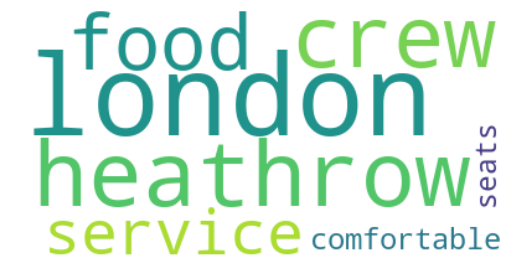

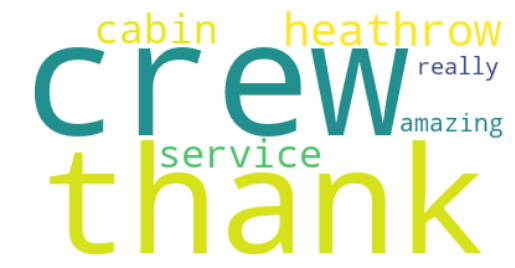

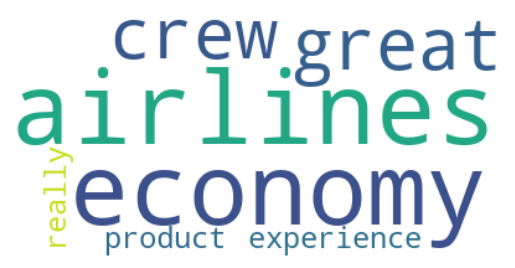

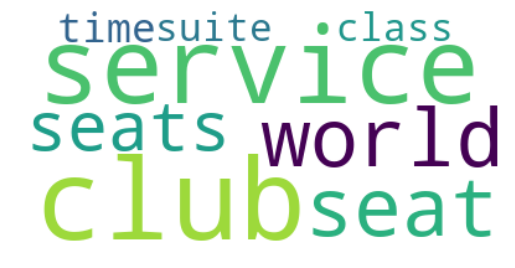

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

filt=['ba','good','went','flight']
def create_wordcloud(model, topic):
    topic_words = {word: value for word, value in model.get_topic(topic)}
    filtered_words = {word: value for word, value in topic_words.items() if word not in filt}
    
    # Generate the word cloud from the filtered words
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(filtered_words)
    
    # Display the word cloud
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Example usage:
# Assuming 'topic_model' is your topic modeling model and 'topic=1' is the topic you want to visualize
for i in range(0,4,1):
    create_wordcloud(topic_model, topic=i)


In [38]:
vectorizer_model = CountVectorizer(stop_words="english")
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True,vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(neutral_df["reviews"])

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-22 21:33:39,253 - BERTopic - Transformed documents to Embeddings
2023-11-22 21:33:41,042 - BERTopic - Reduced dimensionality
2023-11-22 21:33:41,049 - BERTopic - Clustered reduced embeddings


In [39]:
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,40,-1_flight_ba_seat_service,"[flight, ba, seat, service, london, cabin, tim...",[Belfast City to Atlanta via London Heathrow T...
1,0,31,0_flight_crew_cabin_seat,"[flight, crew, cabin, seat, seats, club, board...",[BA 2616 and 2617 return trip from Gatwick to ...
2,1,30,1_flight_ba_british_airways,"[flight, ba, british, airways, travel, refund,...",[I arrived at the airport about 2.5 hours befo...


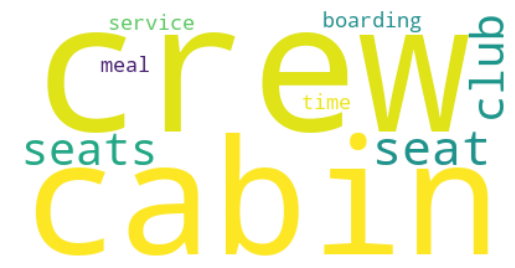

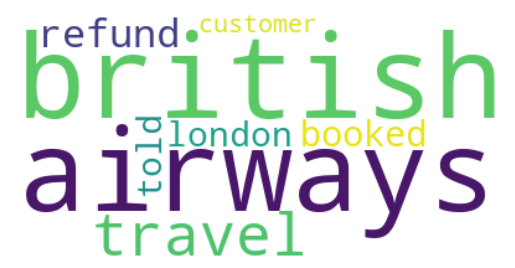

In [40]:
for i in range(0,2,1):
    create_wordcloud(topic_model, topic=i)

In [26]:
vectorizer_model = CountVectorizer(stop_words="english")
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True,vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(negative_df["reviews"])

topic_model.get_topic(0)  # Select the most frequent topic

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

2023-11-22 16:31:12,566 - BERTopic - Transformed documents to Embeddings
2023-11-22 16:31:14,527 - BERTopic - Reduced dimensionality
2023-11-22 16:31:14,561 - BERTopic - Clustered reduced embeddings


[('class', 0.0374749066737208),
 ('seat', 0.034126185597577574),
 ('food', 0.032880108690371584),
 ('flight', 0.03277859550074847),
 ('business', 0.02934766091740511),
 ('ba', 0.029253797802142493),
 ('cabin', 0.028067102133337237),
 ('service', 0.02643823888767207),
 ('crew', 0.026290838804372173),
 ('seats', 0.024766150826397857)]

In [48]:
freq = topic_model.get_topic_info(); freq.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,40,-1_flight_ba_seat_service,"[flight, ba, seat, service, london, cabin, tim...",[Belfast City to Atlanta via London Heathrow T...
1,0,31,0_flight_crew_cabin_seat,"[flight, crew, cabin, seat, seats, club, board...",[BA 2616 and 2617 return trip from Gatwick to ...
2,1,30,1_flight_ba_british_airways,"[flight, ba, british, airways, travel, refund,...",[I arrived at the airport about 2.5 hours befo...


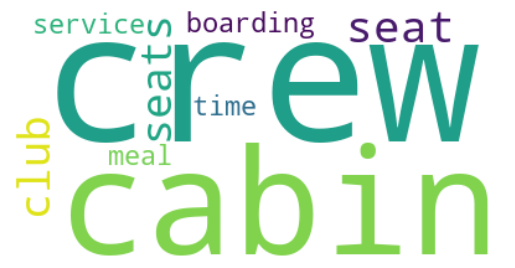

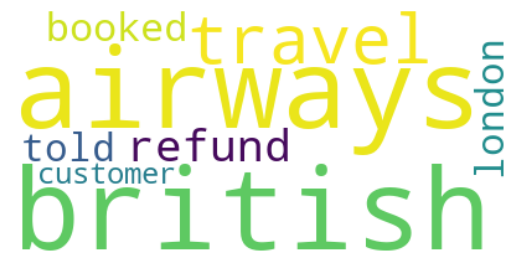

In [46]:
for i in range(0,2,1):
    create_wordcloud(topic_model, topic=i)

all_topic_words = []
for topic in range(num_topics):  # 'num_topics' is the total number of topics in your model
    topic_words = [word for word, _ in topic_model.get_topic(topic)]
    all_topic_words.extend(topic_words)